# Notebook 5 - Lime

### 1. Imports + Setup

In [1]:
from constants import *

In [2]:
import numpy as np
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

import cv2

import glob

import tensorflow
from tensorflow.keras.models import load_model

/Users/lorenzocesconetto/Desktop/ITAU-ANALYTICS/Skin-Cancer/skin_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lorenzocesconetto/Desktop/ITAU-ANALYTICS/Skin-Cancer/skin_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lorenzocesconetto/Desktop/ITAU-ANALYTICS/Skin-Cancer/skin_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)ty

In [3]:
# Set up multiple outputs for cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 2. Constants

In [4]:
IMAGE_SIZE = 224

In [5]:
mobile_net = load_model('mobile_net_v0_0.76.h5', compile=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### 3. Explore melanoma probas

In [6]:
def read_pre_process_predict_imgs(dir_path='../data_processed/train/mel/*.jpg'):
    mel_index = DIAG_2_NUM['mel']
    
    correct_imgs = []
    correct_probas = []
    
    wrong_imgs = []
    wrong_probas = []
    
    count_correct = 0
    
    all_paths = glob.glob(dir_path)
    
    for path in all_paths:
        # Read image
        img = plt.imread(path)
        
        # Resize
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        
        # MobileNet pre process
        img = tensorflow.keras.applications.mobilenet.preprocess_input(img)
        
        # Predict
        probas = mobile_net.predict(np.expand_dims(img, axis=0))
        index = np.argmax(probas)
        disease = NUM_2_DIAG[index]
        
        if disease == 'mel':
            count_correct += 1
            correct_imgs.append(path)
            correct_probas.append(probas[0, mel_index])
        else:
            wrong_imgs.append(path)
            wrong_probas.append(probas[0, mel_index])
    
    print('count_correct:', count_correct)
    print('accuracy:', count_correct / len(all_paths))
    return correct_imgs, correct_probas, wrong_imgs, wrong_probas

In [7]:
NUM_2_DIAG

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'nv', 5: 'vasc', 6: 'mel'}

In [8]:
correct_imgs, correct_probas, wrong_imgs, wrong_probas = read_pre_process_predict_imgs()

count_correct: 24
accuracy: 0.015915119363395226


### 4. Visualize right and wrong

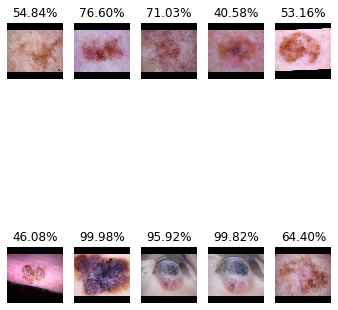

In [14]:
fig = plt.figure(figsize=(12, 12))
for i in range(10):
    img = plt.imread(correct_imgs[i])
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    _ = plt.subplot(2, 5, i + 1, title='{0:.2%}'.format(correct_probas[i]))
    _ = plt.axis('off')
    _ = plt.imshow(img)

fig.subplots_adjust(right=.5, top=0.6)
# fig.savefig('')

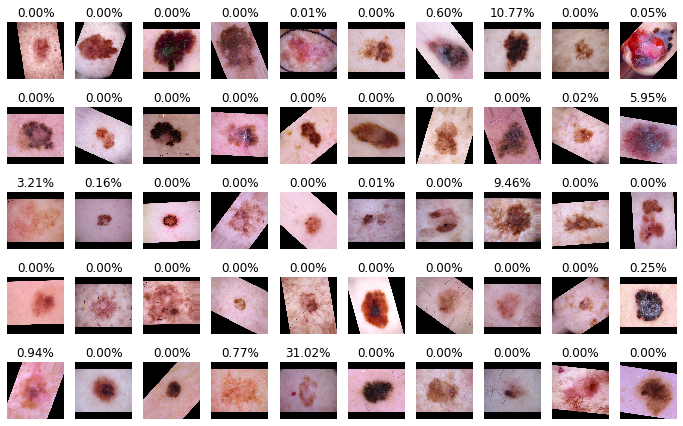

In [17]:
fig = plt.figure(figsize=(12, 12))
for i in range(50):
    img = plt.imread(wrong_imgs[i])
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    _ = plt.subplot(5, 10, i + 1, title='{0:.2%}'.format(wrong_probas[i]))
    _ = plt.axis('off')
    _ = plt.imshow(img)

fig.subplots_adjust(top=.6)
# fig.savefig('')

### 5. Interpretation on right classification

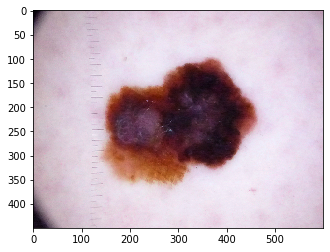

In [12]:
img_1 = plt.imread(right_imgs[0])
plt.imshow(img_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


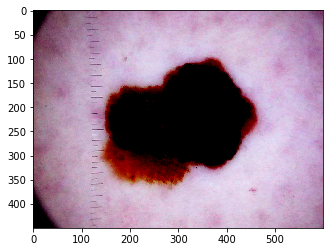

In [13]:
img_1 = cv2.resize(img_1, (IMAGE_SIZE, IMAGE_SIZE))
img_1 = tensorflow.keras.applications.mobilenet.preprocess_input(img_1)
plt.imshow(img_1)

In [15]:
probs = mobile_net.predict(np.expand_dims(img_1, axis=0))
probs
np.argmax(probs)
index_to_classs[str(np.argmax(probs))]

array([[2.63935651e-09, 1.01054116e-10, 1.61679651e-07, 2.62712047e-10,
        9.99125540e-01, 8.74330057e-04, 1.61444968e-13]], dtype=float32)

4

'mel'

In [17]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_1, mobile_net.predict, top_labels=2, num_samples=1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


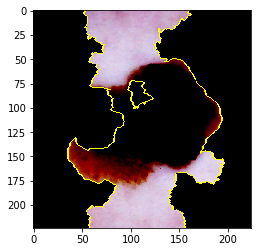

In [30]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, 
                                            num_features=9, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


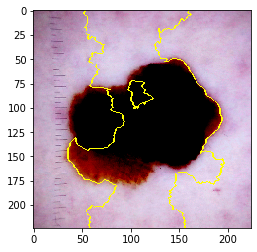

In [29]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, 
                                            num_features=9, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


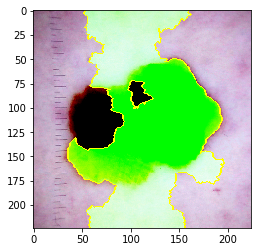

In [32]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                            num_features=9, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


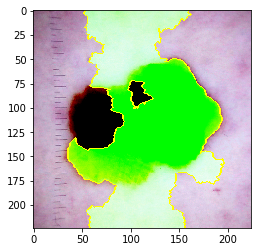

In [39]:
# min_weight=0.0015
# min_weight=0.002
# min_weight=0.001
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            num_features=9, 
                                            hide_rest=False,
                                            min_weight=0.01)
plt.imshow(mark_boundaries(temp, mask))

### 6. Interpretation on wrong classifications

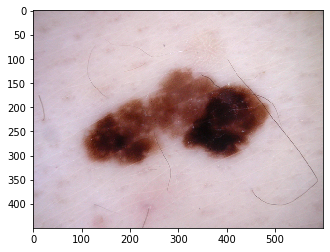

In [40]:
img_2 = plt.imread(wrong_imgs[38])
plt.imshow(img_2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


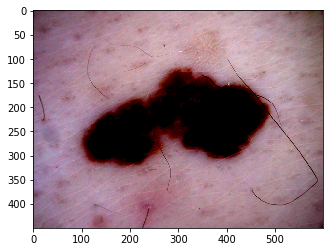

In [41]:
img_2 = cv2.resize(img_2, (IMAGE_SIZE, IMAGE_SIZE))
img_2 = tensorflow.keras.applications.mobilenet.preprocess_input(img_2)
plt.imshow(img_2)

In [43]:
probs = mobile_net.predict(np.expand_dims(img_2, axis=0))
probs
np.argmax(probs)
index_to_classs[str(np.argmax(probs))]

array([[1.0958442e-14, 4.2415066e-14, 1.1678498e-09, 8.8204340e-11,
        3.6151665e-03, 9.9638486e-01, 4.1725094e-17]], dtype=float32)

5

'nv'

In [61]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_2, mobile_net.predict, top_labels=2, num_samples=1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


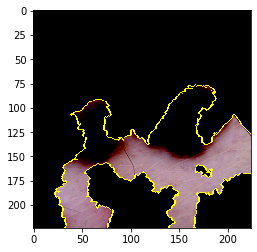

In [62]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=9, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


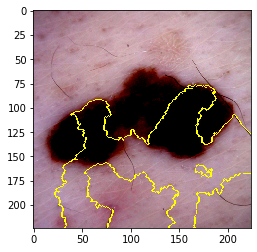

In [63]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=9, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


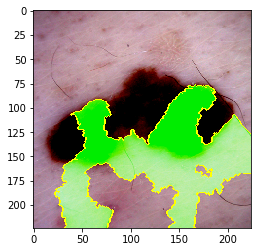

In [64]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=9, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


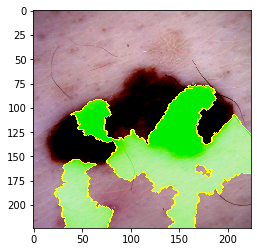

In [65]:
# min_weight=0.0015
# min_weight=0.002
# min_weight=0.001
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            num_features=9, 
                                            hide_rest=False,
                                            min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask))